# Starbucks Capstone Challenge

## Part III: Modeling

## Table of Content
[1 Import Packages and Load Data](#1-bullet) <br>
[2 Perform FunkSVD](#2-bullet) <br>
[3 K-Means Clustering](#3-bullet) <br>
[4 Multi Armed Bandit](#4-bullet) <br>
&emsp;[4.1 MAB Simulation](#4.1-bullet) <br>
&emsp;[4.2 MAB Test](#4.2-bullet) <br>

## 1 Import Packages and Load Data<a class="anchor" id="1-bullet"></a>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#clustering
from sklearn.model_selection import ShuffleSplit
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score  
import os

from mab import *
from tqdm import tqdm
import seaborn as sns

In [2]:
df_member = pd.read_csv('../data/df_member.csv', sep='\t')
df_mab = pd.read_csv('../data/df_mab.csv', sep='\t')

##  2 Perform FunkSVD <a class="anchor" id="2-bullet"></a>

In [3]:
# Create user-by-item matrix
user_items = df_mab[['member_id', 'offer_name', 'performance','time']].copy()
user_by_offer = user_items.groupby(['member_id', 'offer_name'])['performance'].mean().round(2).unstack()
user_by_offer

offer_name,No_offer,bogo_df10_rw10_du5,bogo_df10_rw10_du7,bogo_df5_rw5_du5,bogo_df5_rw5_du7,disc_df10_rw2_du10,disc_df10_rw2_du7,disc_df20_rw5_du10,disc_df7_rw3_du7,info_df0_rw0_du3,info_df0_rw0_du4
member_id,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,2.50,NaN,NaN,1.0,NaN,1.00,NaN,NaN,NaN,2.0,2.0
00116118485d4dfda04fdbaba9a87b5c,1.67,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.67,NaN,NaN,NaN,4.0,NaN,NaN,3.0,1.0,1.0,1.0
0020c2b971eb4e9188eac86d93036a77,3.17,1.0,NaN,NaN,NaN,2.00,NaN,NaN,NaN,NaN,NaN
0020ccbbb6d84e358d3414a3ff76cffd,2.38,NaN,NaN,4.0,2.0,NaN,NaN,NaN,1.0,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,2.00,NaN,NaN,NaN,1.0,2.00,NaN,NaN,NaN,4.0,NaN
fff7576017104bcc8677a8d63322b5e1,0.50,1.0,1.0,NaN,NaN,2.25,NaN,NaN,NaN,NaN,NaN
fff8957ea8b240a6b5e634b6ee8eafcf,1.80,1.0,NaN,NaN,NaN,1.00,NaN,NaN,NaN,NaN,NaN


In [4]:
# How many actual ratings exist in first_1000_users
num_ratings = np.count_nonzero(~np.isnan(user_by_offer))
print('The number of actual ratings in the user_by_offer is {}.'.format(num_ratings))
print()

# How many ratings did we make for user-offer pairs that didn't have ratings
ratings_for_missing = user_by_offer.shape[0]*user_by_offer.shape[1] - num_ratings
print("The number of ratings made for user-offer pairs that didn't have ratings is {}.".format(ratings_for_missing))

The number of actual ratings in the user_by_offer is 64465.

The number of ratings made for user-offer pairs that didn't have ratings is 122425.


In [5]:
#Create Ratings Matrix
ratings_mat = np.matrix(user_by_offer)

In [6]:
def FunkSVD(ratings_mat, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, movies as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0]
    n_offers = ratings_mat.shape[1]
    num_ratings = np.count_nonzero(~np.isnan(ratings_mat))
    
    # initialize the user and offer matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print('Optimizaiton Statistics')
    print('Iterations | Mean Squared Error ')
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if ratings_mat[i, j] > 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = ratings_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results for iteration
        print('%d \t\t %f' % (iteration+1, sse_accum / num_ratings))
        
    return user_mat, offer_mat 

In [7]:
user_mat, offer_mat = FunkSVD(ratings_mat, latent_features=10, learning_rate=0.005, iters=30)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 1.139377
2 		 1.074244
3 		 1.025470
4 		 0.981576
5 		 0.942040
6 		 0.906343
7 		 0.873983
8 		 0.844480
9 		 0.817374
10 		 0.792221
11 		 0.768587
12 		 0.746050
13 		 0.724192
14 		 0.702606
15 		 0.680896
16 		 0.658691
17 		 0.635655
18 		 0.611509
19 		 0.586049
20 		 0.559176
21 		 0.530905
22 		 0.501385
23 		 0.470890
24 		 0.439805
25 		 0.408590
26 		 0.377740
27 		 0.347733
28 		 0.318989
29 		 0.291841
30 		 0.266525


In [8]:
print(np.dot(user_mat, offer_mat).round(2))
print(ratings_mat)

[[ 2.15  2.37  2.11 ...  2.55  1.18  1.58]
 [ 1.61  1.79  2.1  ... -0.23  0.92  0.92]
 [ 2.13  2.85  3.09 ...  0.8   0.79  1.11]
 ...
 [ 1.31  1.11  1.34 ...  1.31  1.94  1.13]
 [ 2.36  0.1   0.18 ...  3.24  4.07  1.86]
 [ 2.22  2.14  1.94 ...  1.42  2.26  0.29]]
[[2.5   nan  nan ...  nan 2.   2.  ]
 [1.67  nan  nan ...  nan  nan  nan]
 [1.67  nan  nan ... 1.   1.   1.  ]
 ...
 [1.8  1.    nan ...  nan  nan  nan]
 [2.44  nan  nan ...  nan 4.    nan]
 [3.12  nan  nan ...  nan  nan  nan]]


In [9]:
df_cluster = pd.DataFrame(data=np.dot(user_mat, offer_mat).round(2), 
                  index=user_by_offer.index,
                  columns=user_by_offer.columns) 
df_cluster.columns.name = None

## 3 K-Means Clustering<a class="anchor" id="3-bullet"></a>

In [10]:
pd.set_option('display.max_columns', None)
df = df_member[['member_id','nr_purch','amount_median','amount_std','compl_offers','nr_NUO','days_reg']].copy()
df['nr_NUO'] = df['nr_NUO'].fillna(0)
df['amount_std'] = df['amount_std'].fillna(0)
# Including users' income features
if not 'nr_purch' in df_cluster.columns:
    df_cluster = pd.merge(df_cluster, df, on = 'member_id', how='inner')
    print('Merge completed')
df_cluster.set_index('member_id', inplace=True)
df_cluster.drop(['No_offer','info_df0_rw0_du3','info_df0_rw0_du4'], axis=1, inplace=True)

Merge completed


In [11]:
#Replace Outliers with next max/min value
for column in df_cluster:
    median = df_cluster[column].median()
    std = df_cluster[column].std()
    outliers = (df_cluster[column] - median).abs() > std
    mi = df_cluster[column][outliers==False].min()
    ma = df_cluster[column][outliers==False].max()
    df_cluster[column] = np.where(df_cluster[column]> ma,ma,df_cluster[column])
    df_cluster[column] = np.where(df_cluster[column]< mi,mi,df_cluster[column])

In [12]:
n_folds = 5
ss = ShuffleSplit(n_splits=n_folds, train_size=.75, test_size=.2, random_state=0)
silhouette_avg = list()
arr_n_clusters = np.arange(2, 10, 1)
X = df_cluster.values
df_silhouette_avg = pd.DataFrame(columns = ['fold', 'n_cluster', 'train_silhouette', 'test_silhouette'])
trained_models = list()

for fold, [train_index, val_index] in enumerate(ss.split(X)):
    
    print ('Running analysis on fold {}'.format(fold))
    X_train, X_val = X[train_index], X[val_index]
    
    for n_cluster in arr_n_clusters:        
        model = KMeans(n_clusters=n_cluster, random_state=0)
        
        model.fit(X_train)
        train_silhouette = silhouette_score(X_train, model.predict(X_train))
        val_silhouette = silhouette_score(X_val, model.predict(X_val))

        row = [fold, n_cluster, train_silhouette, val_silhouette]
        df_silhouette_avg.loc[df_silhouette_avg.shape[0]] = row 

Running analysis on fold 0
Running analysis on fold 1
Running analysis on fold 2
Running analysis on fold 3
Running analysis on fold 4


Text(0, 0.5, 'Silhouette Score')

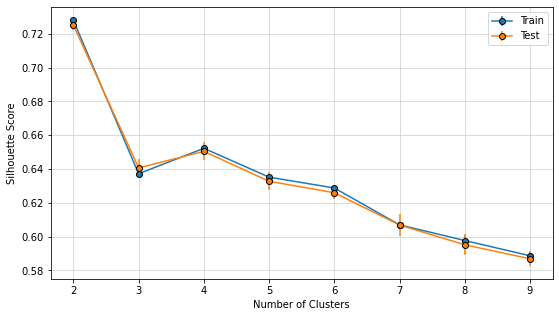

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,5))
df_plot = df_silhouette_avg.groupby('n_cluster')
for i, set_label in enumerate(['train', 'test']):
    ax.errorbar(df_plot.mean().index,                 df_plot.mean()[set_label + '_silhouette'].values, 
                df_plot.std()[set_label + '_silhouette'].values, label=set_label.title(),
               marker='o', mec='black')
ax.set_xticks(arr_n_clusters), ax.set_xticklabels(arr_n_clusters)

ax.grid(True, color='lightgray')
ax.legend()
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

Considering the silhouette score, a proper number of clusters would be 4.

### Final K-means Cluster

In [14]:
n_clusters = 4
model = KMeans(n_clusters=n_clusters, random_state=0, verbose=False)
model.fit(X)

KMeans(n_clusters=4, random_state=0, verbose=False)

In [15]:
df_clusters_rewards = pd.DataFrame(model.cluster_centers_)
df_clusters_rewards.columns = df_cluster.columns
df_clusters_rewards = df_clusters_rewards.reset_index(drop=False).rename({'index': 'cluster'},axis=1).set_index('cluster')
df_clusters_rewards.drop(['nr_purch','amount_median','amount_std','compl_offers','nr_NUO','days_reg'], axis=1, inplace=True)
df_clusters_rewards

,bogo_df10_rw10_du5,bogo_df10_rw10_du7,bogo_df5_rw5_du5,bogo_df5_rw5_du7,disc_df10_rw2_du10,disc_df10_rw2_du7,disc_df20_rw5_du10,disc_df7_rw3_du7
cluster,,,,,,,,
0,1.649841,1.700102,1.836416,1.942952,2.288169,2.013917,2.021862,2.361536
1,1.486259,1.538054,1.623564,1.753984,2.043124,1.818019,1.821579,2.061733
2,1.687759,1.740170,1.845693,1.923072,2.284660,2.000671,2.036516,2.356811
3,1.345699,1.419655,1.500539,1.655674,1.871059,1.674865,1.658344,1.898647


In [16]:
df_cluster['cluster'] = model.labels_
df_cluster['cluster'].value_counts()

0    5670
1    5072
3    3603
2    2233
Name: cluster, dtype: int64

## 4 Multi Armed Bandit<a class="anchor" id="4-bullet"></a>

Now that we have the mean reward for each cluster, we can model them as a multi-armed bandit (MAB). Each cluster shall be considered as a MAB and each product is an arm to be pulled.

Many algorithms have been proposed as a MAB. For this project, we will use the -greedy-decay algorithm because we want to explore in the begining and then slowly start exploiting the most rewarding arms.

However, a slight modification has been made to the algorithm. Since there are few products and we don't want users to always receive the same recommendation, a threshold  has been set to guarantee a minimum exploration when the optimization converges. In other words, the  parameter starts with a high value and, as the epochs continue, it keeps decreasing until it reaches a threshold where it remains with a fixed value.

### 4.1 MAB Simulation <a class="anchor" id="4.1-bullet"></a>

In [17]:
%%time

T = 3000
realizations = 20 #20*7Cluster = 140
epsilon = 0.3
beta = 0.001
print ('Starting MAB Experiment')

mean_reward_hist = pd.DataFrame(columns=[i for i in np.arange(T+1)] + ['realization'])

for realization in tqdm(np.arange(realizations)):
    last_reward = np.zeros(n_clusters)
    bandits = [EGreedyDecay(epsilon=epsilon, beta=beta) for _ in np.arange(n_clusters)]
    for i in np.arange(n_clusters):
        bandits[i].set_rewards(df_clusters_rewards.loc[i])

    temp_mean_reward_hist = dict()
    for cluster in np.arange(n_clusters):
        temp_mean_reward_hist[cluster] = []

    for t in range(1,T):
        for cluster in np.arange(n_clusters):
            item = bandits[cluster].pull_arm(last_reward[cluster]) 
            last_reward[cluster] = bandits[cluster].get_reward(item) 
            temp_mean_reward_hist[cluster].append(bandits[cluster].mean_reward)

    temp_mean_reward_hist = pd.DataFrame(temp_mean_reward_hist).T
    temp_mean_reward_hist['realization'] = realization
    mean_reward_hist = pd.concat([mean_reward_hist, temp_mean_reward_hist], sort=False)
    
mean_reward_hist = mean_reward_hist.reset_index(drop=False).rename({'index': 'cluster'}, axis=1)

Starting MAB Experiment


100%|██████████| 20/20 [00:07<00:00,  2.84it/s]

CPU times: total: 7.61 s
Wall time: 7.13 s


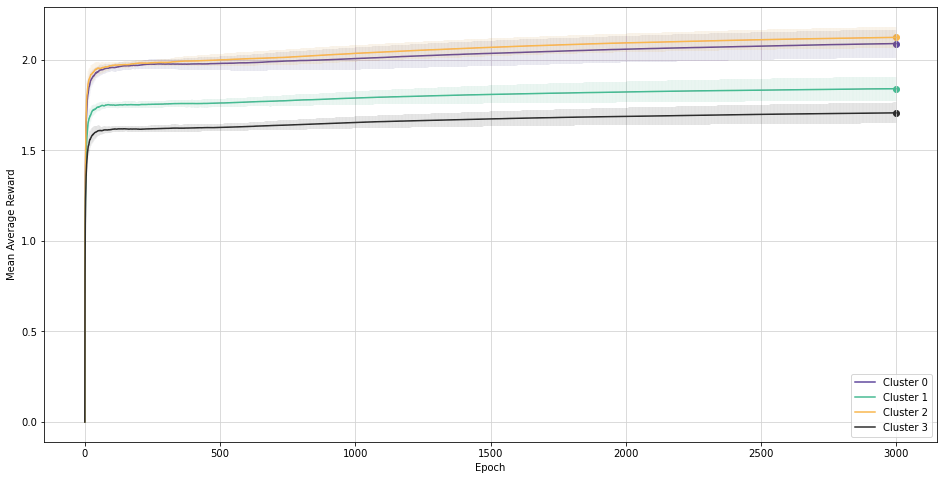

In [18]:
second_palette = ['#60489D', '#46BB93', '#F9B74D', '#2D2D2D', '#9F1253', '#559EE1', '#EE8348', '#A9A8A8', '#56DCE3', '#4260AD']

fig, ax = plt.subplots(figsize=(16,8))
df_plot_mean = mean_reward_hist.iloc[:,0:-3].groupby(['cluster']).mean()
df_plot_std = mean_reward_hist.iloc[:,0:-3].groupby(['cluster']).std()
for cluster in np.arange(n_clusters):
    ax.plot(df_plot_mean.iloc[cluster], 
            label = 'Cluster ' + str(cluster), 
            color=second_palette[cluster], alpha=1)
    
    ax.errorbar(df_plot_mean.columns,
                df_plot_mean.iloc[cluster],                
                df_plot_std.iloc[cluster], 
           color=second_palette[cluster], 
               alpha=.02, label=None)
    
    ax.scatter(x=[T], y=[np.array(df_plot_mean.loc[cluster])[-1]], 
               color=second_palette[cluster], label=None)
    
ax.set_xlabel('Epoch'), ax.set_ylabel('Mean Average Reward')
ax.legend()
ax.grid(True, color='lightgray')

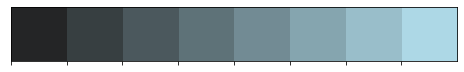

In [19]:
palette = 'lightblue'
sns_palette = sns.dark_palette(palette, n_colors=8)
sns.palplot(sns_palette)
sns.set_palette(sns_palette)
sns.set(font_scale=1.2)

4 [ 191.  206.  175.  154. 1755.  174.  163.  181.]
5 [ 186.  251.  253.  164.  181. 1616.  192.  156.]
7 [ 166.  174.  176.  154.  161.  173.  176. 1819.]
4 [ 198.  185.  184.  190. 1698.  202.  163.  179.]


Text(0.5, 1.0, '#picks for each offer')

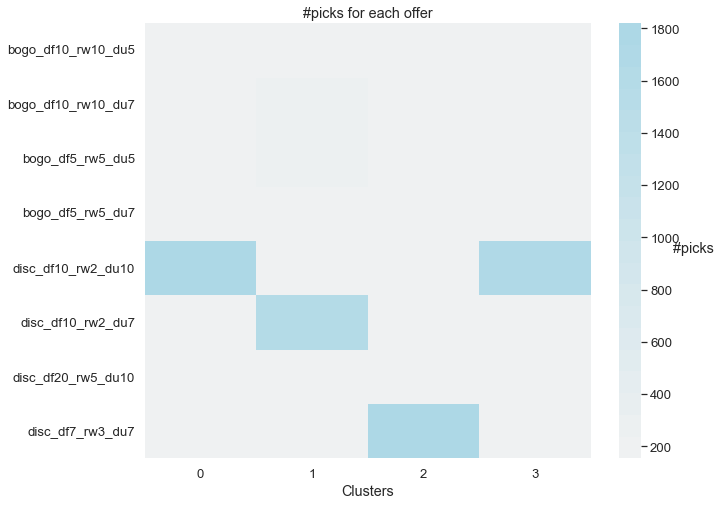

In [20]:
picks = np.zeros([n_clusters, bandits[0].k])
for cluster, bandit in enumerate(bandits):
    picks[cluster] = bandit.k_n
    print (np.argmax(bandit.k_n), bandit.k_n)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(picks.T, ax=ax, cmap=sns.light_palette(palette, n_colors=20))
ax.set_xlabel('Clusters')
ax.set_yticklabels([product for product in df_clusters_rewards.columns], rotation = 0)
ax.collections[0].colorbar.set_label('     #picks', rotation=0)
ax.set_title('#picks for each offer')


### 4.2 MAB Test<a class="anchor" id="4.2-bullet"></a>

In [21]:
import joblib
import pickle

data_dir = '../data/'
#with open(os.path.join(data_dir, os.path.join(data_dir, 'trained_svd.pkl')), 'wb') as file: 
#    pickle.dump(svd, file)

with open(os.path.join(data_dir, os.path.join(data_dir, 'trained_kmeans.pkl')), 'wb') as file: 
    pickle.dump(model, file)

for cluster, bandit in enumerate(bandits):
    joblib.dump(bandit, os.path.join(data_dir,  'trained_{}_cluster_{}.joblib'.format(str(bandit), cluster)))
    with open(os.path.join(data_dir,  'trained_{}_cluster_{}.pkl'.format(str(bandit), cluster)), 'wb') as file: 
        pickle.dump(bandit, file)
#session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print ('Data Uploaded')

Data Uploaded


In [22]:
#Select a random customer
customer = df_cluster.sample().index
print(customer[0])

96335586a1a645e8918f6810a1fc1375


In [23]:
#identify cluster of customer
cluster = df_cluster[df_cluster.index==customer[0]].iloc[:,-1][-1]
print('Member cluster: ', cluster)

Member cluster:  0


In [28]:
with open('../data/trained_EGreedyDecay_cluster_{}.pkl'.format(cluster), 'rb') as f:
    data = pickle.load(f)

In [29]:
#Print first 10 offers for customer
for i in range(10):
    print(data.pull_arm(i))

disc_df10_rw2_du10
disc_df10_rw2_du10
disc_df10_rw2_du10
disc_df20_rw5_du10
disc_df10_rw2_du10
bogo_df5_rw5_du7
disc_df10_rw2_du7
disc_df20_rw5_du10
bogo_df5_rw5_du7
disc_df10_rw2_du10
